# Diversity Test

This notebook compares categorical index diversity in the ranked recommendations. If you want to see distance comparisons, head out to the next note. 

Number of sampled actions: 50

``` ddpg_action = ddpg_action[np.random.randint(0, 5000, 50)].detach().cpu().numpy() <- that 50 ```

K parameter for TopK ranking: 20 (changed in the query function arguments)

Next part contains A LOT of various graphs that are not grouped. If you want GROUPED comparison, go to the bottom section

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
import numpy as np
from scipy.spatial import distance
from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py
import pandas as pd

from IPython.display import clear_output
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

def load_file(path, name):
    import importlib.util
    spec = importlib.util.spec_from_file_location(name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

models = load_file("../../utils/models.py", "models")
data = load_file("../../utils/data.py", "data")

cuda = torch.device('cuda')
frame_size = 10
tqdm.pandas()

In [9]:
ddpg = models.Actor(1290, 128, 256).to(cuda)
td3 = models.Actor(1290, 128, 256).to(cuda)
ddpg.load_state_dict(torch.load('../../models/DDPG/ddpg_policy.pt'))
td3.load_state_dict(torch.load('../../models/TD3/td3_policy_1.pt'))

<All keys matched successfully>

In [10]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_ref = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
movie_ref_tensor, key_to_id, id_to_key = data.make_movie_tensor(movie_ref)
# download ml20m dataset yourself
ratings = pd.read_csv('../../data/ml-20m/ratings.csv')
user_dict, users = data.prepare_tensor(ratings, key_to_id, frame_size)
del ratings
gc.collect()
clear_output(True)
clear_output(True)
print('Done!')

Done!


In [11]:
test_users = users[-5000:]
batch_size = 25

def prepare_batch_wrapper(x):
    batch = data.prepare_batch(x, movie_ref_tensor, frame_size=frame_size)
    return batch

test_user_dataset = data.UserDataset(test_users, user_dict)
test_dataloader = DataLoader(test_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4,collate_fn=prepare_batch_wrapper)
test_batch = next(iter(test_dataloader))
state = test_batch[0].to(cuda)

In [12]:
def rank(gen_action, metric):
    scores = []
    for i in movie_ref.keys():
        scores.append([i, metric(movie_ref[i], gen_action)])
    scores = list(sorted(scores, key = lambda x: x[1]))
    scores = scores[:10]
    ids = [i[0] for i in scores]
    dist = [i[1] for i in scores]

    return ids, dist

# Faiss indexing

In [13]:
import faiss
# test indexes
indexL2 = faiss.IndexFlatL2(128)
indexIP = faiss.IndexFlatIP(128)
indexCOS = faiss.IndexFlatIP(128)

mov_mat  = np.stack(movie_ref.values()).astype('float32')
indexL2.add(mov_mat)
indexIP.add(mov_mat)
indexCOS.add(normalize(mov_mat, axis=1, norm='l2'))

def query(index, action, k=20):
    D, I = index.search(action, k)
    return D, I

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys


# DDPG

In [14]:
ddpg_action = ddpg(state)
ddpg_action = ddpg_action[np.random.randint(0, state.size(0), 50)].detach().cpu().numpy() 

## L2: number the movie was recommended

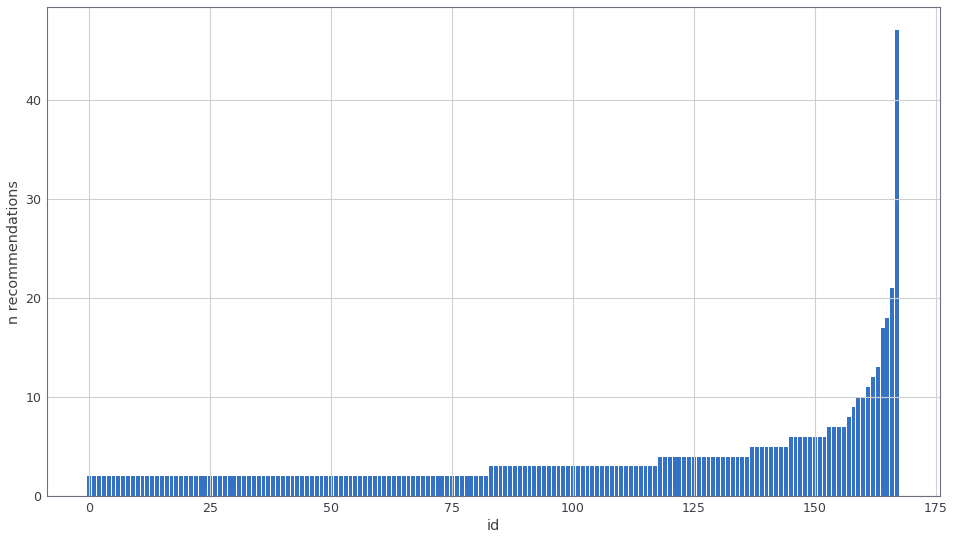

In [15]:
%matplotlib inline

D, I = query(indexL2, ddpg_action)
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts[counts>1])), sorted(counts[counts>1]))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")

l2_ddpg = counts

## L2: counts of n recommendations 

Text(0, 0.5, 'n counts')

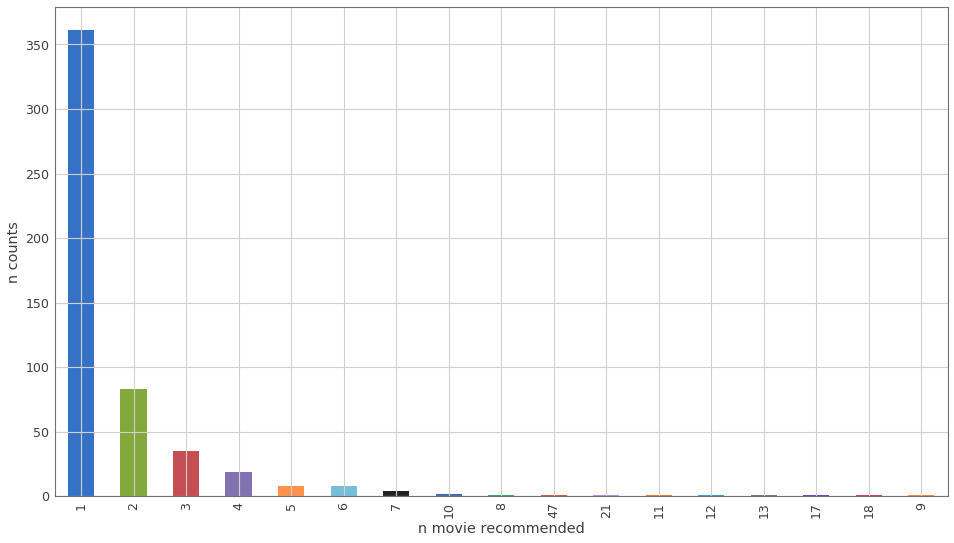

In [16]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

## InnerProduct

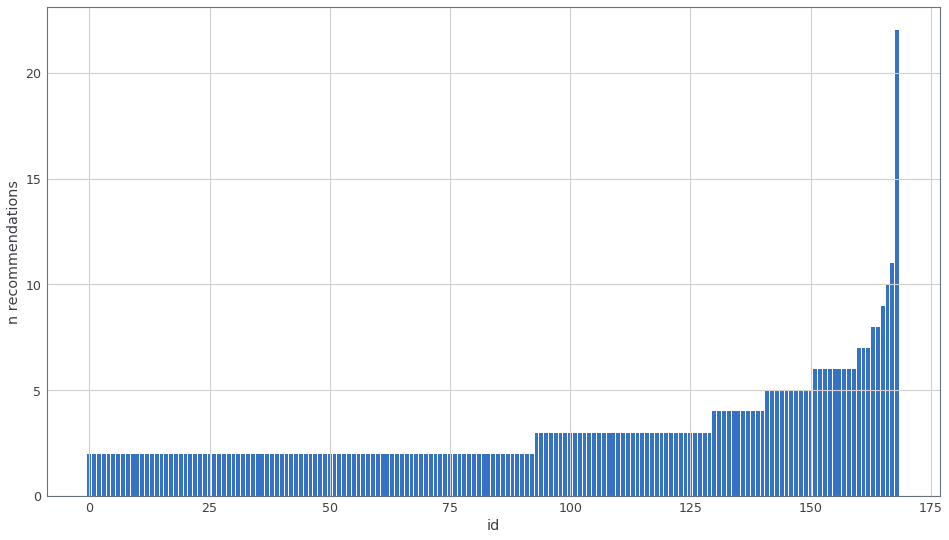

In [17]:
D, I = query(indexIP, ddpg_action)
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts[counts>1])), sorted(counts[counts>1]))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")

ip_ddpg = counts

Text(0, 0.5, 'n counts')

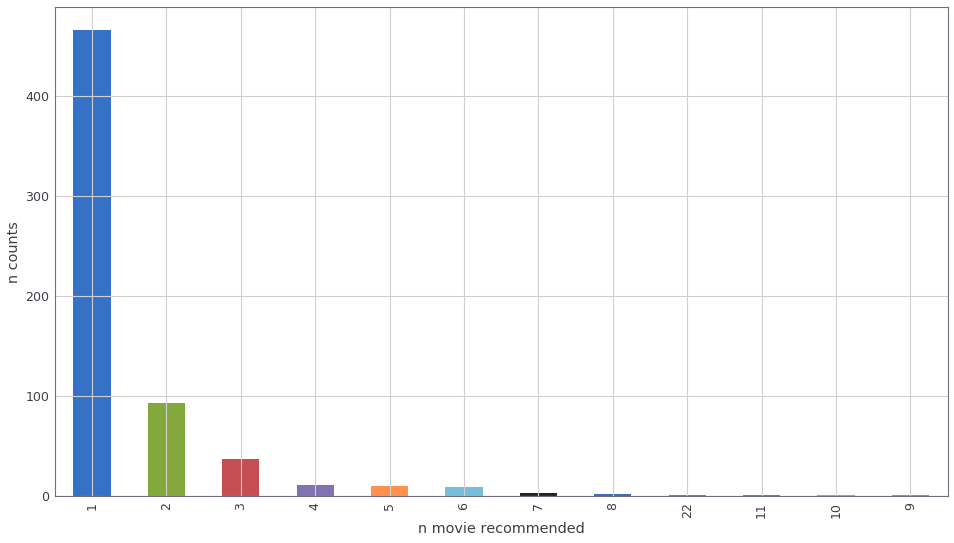

In [18]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

# Cosine Distance

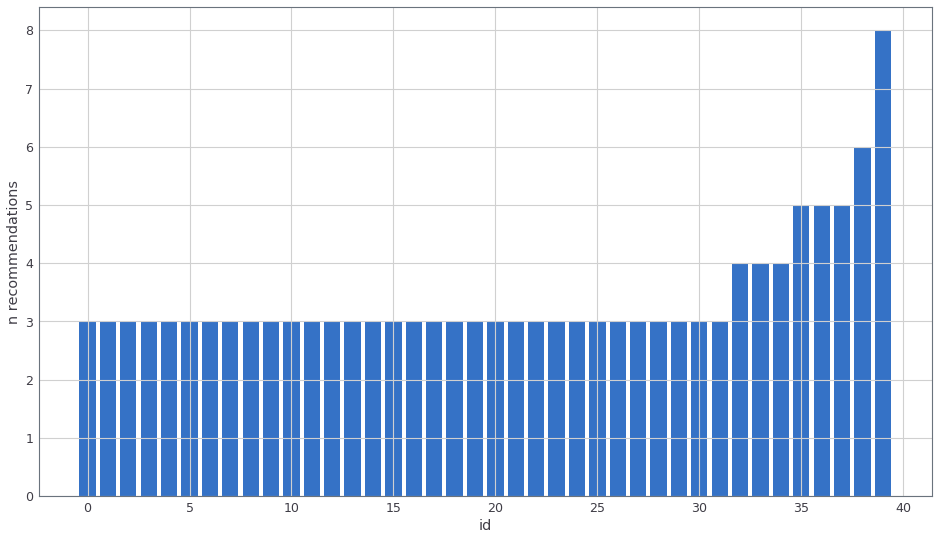

In [19]:
%matplotlib inline

D, I = query(indexCOS, normalize(ddpg_action, axis=1, norm='l2'))
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts[counts>2])), sorted(counts[counts>2]))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")

cos_ddpg = counts

Text(0, 0.5, 'n counts')

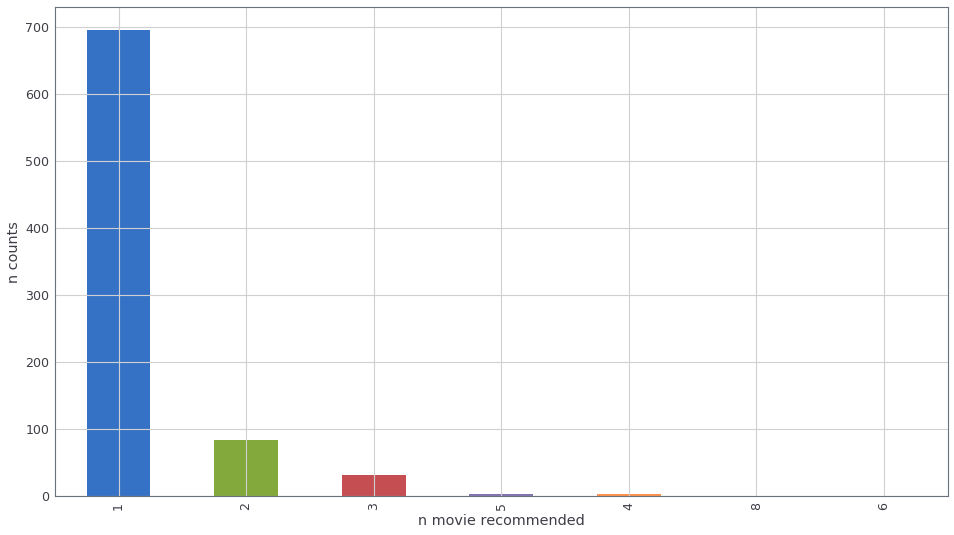

In [20]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

# TD3

In [21]:
td3_action = td3(state)
td3_action = td3_action[np.random.randint(0, state.size(0), 50)].detach().cpu().numpy() 

## L2

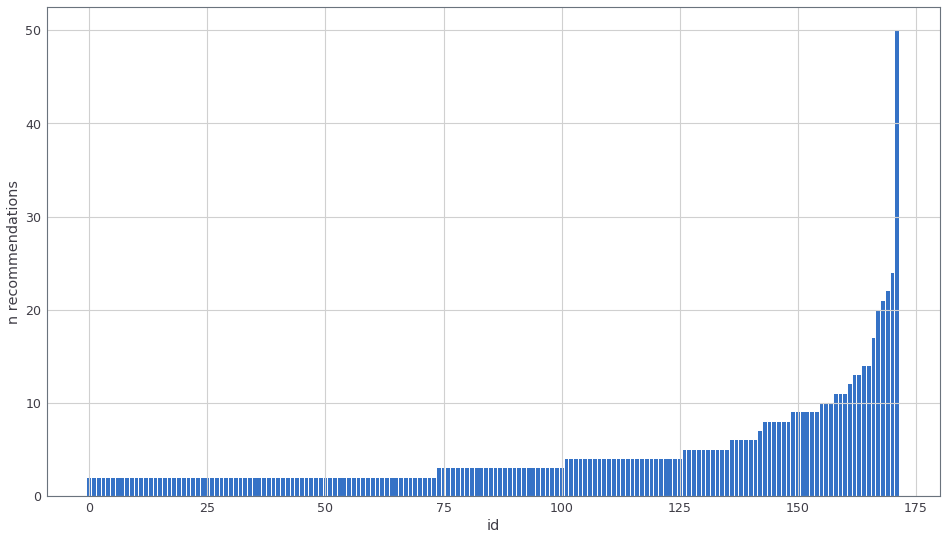

In [22]:
D, I = query(indexL2, td3_action)
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts[counts>1])), sorted(counts[counts>1]))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")
l2_td3 = counts

Text(0, 0.5, 'n counts')

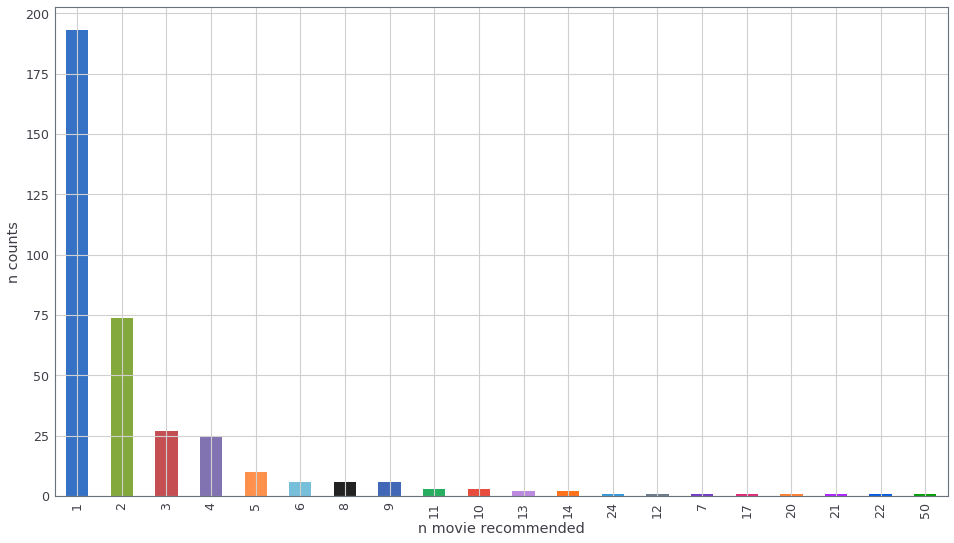

In [23]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

# InnerProduct

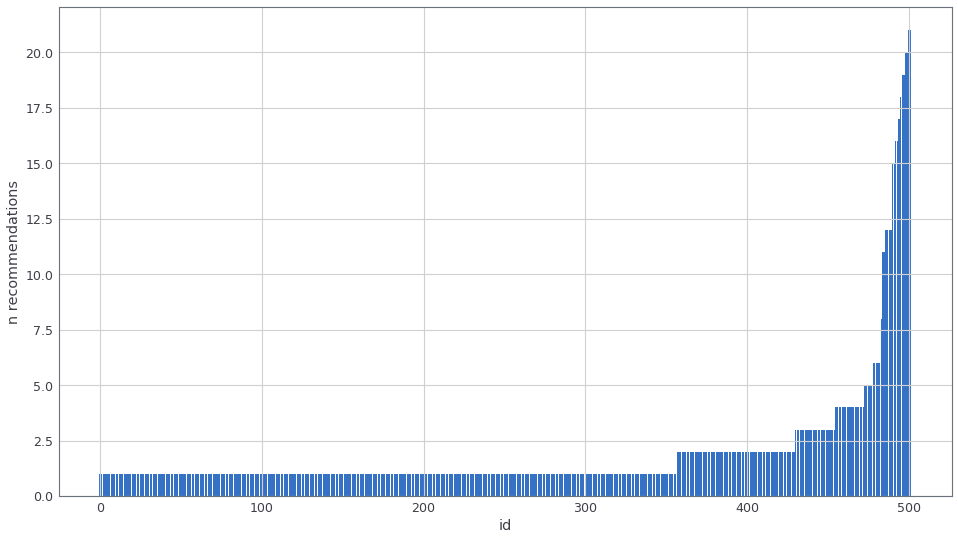

In [24]:
D, I = query(indexIP, td3_action)
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts)), sorted(counts))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")
ip_td3 = counts

Text(0, 0.5, 'n counts')

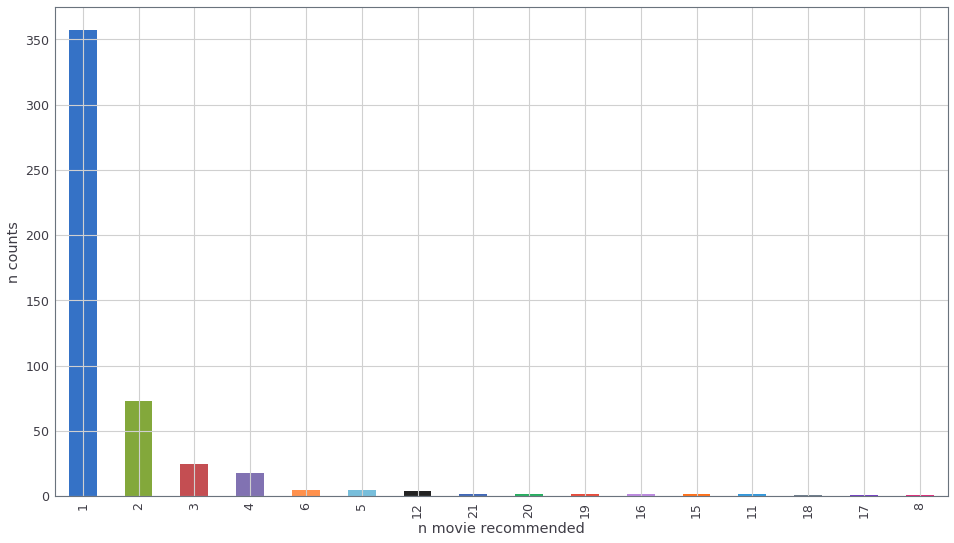

In [25]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

## Cosine Distance

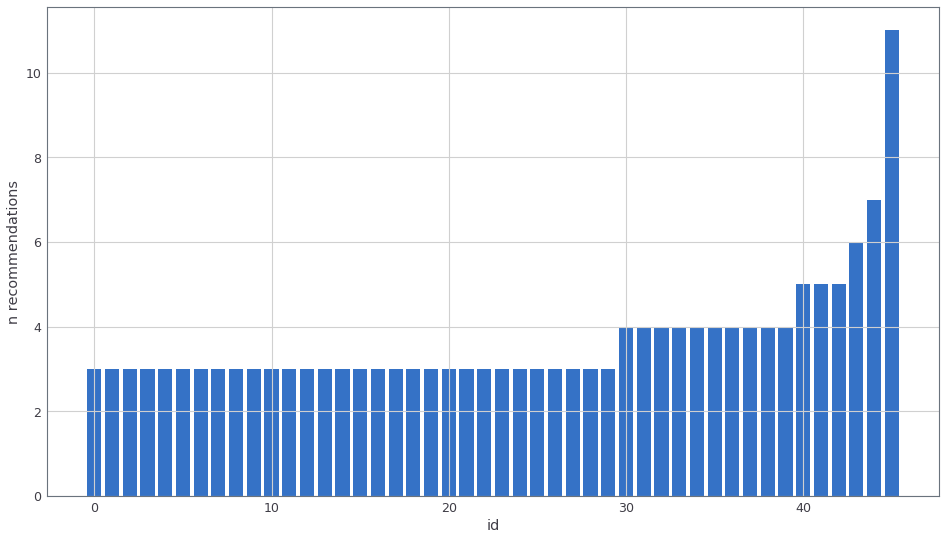

In [26]:
D, I = query(indexCOS, normalize(td3_action, axis=1, norm='l2'))
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts[counts>2])), sorted(counts[counts>2]))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")

cos_td3 = counts

Text(0, 0.5, 'n counts')

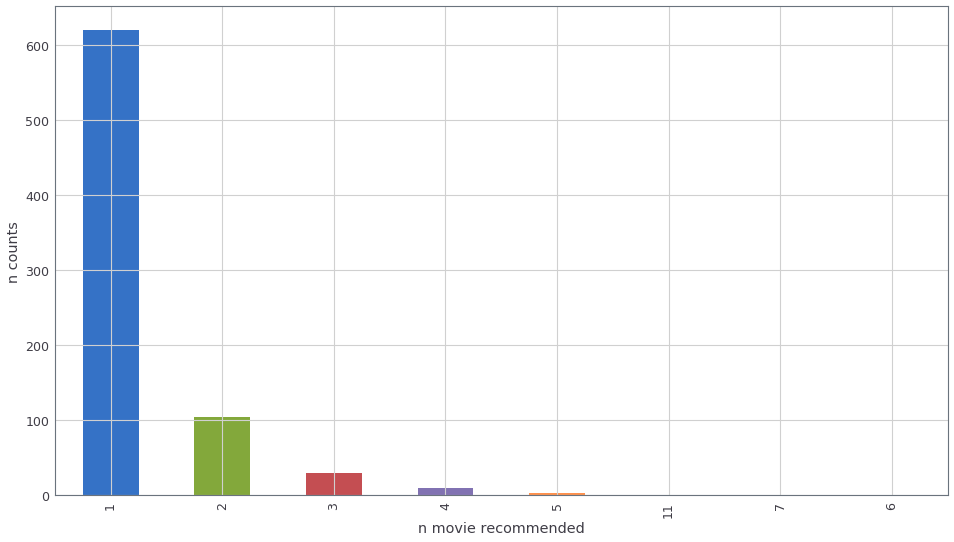

In [27]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

# BCQ

In [28]:
perturbator = models.bcqPerturbator(1290, 128, 256).to(cuda)
generator = models.bcqGenerator(1290, 128, 512).to(cuda)

perturbator.load_state_dict(torch.load('../../models/BCQ/bcq_policy.pt'))
generator.load_state_dict(torch.load('../../models/BCQ/bcq_vae.pt'))

<All keys matched successfully>

In [30]:
sampled_actions = generator.decode(state)
perturbed_actions= perturbator(state, sampled_actions)
bcq_action = perturbed_actions[np.random.randint(0,
                               state.size(0), 50)].detach().cpu().numpy() 

## L2

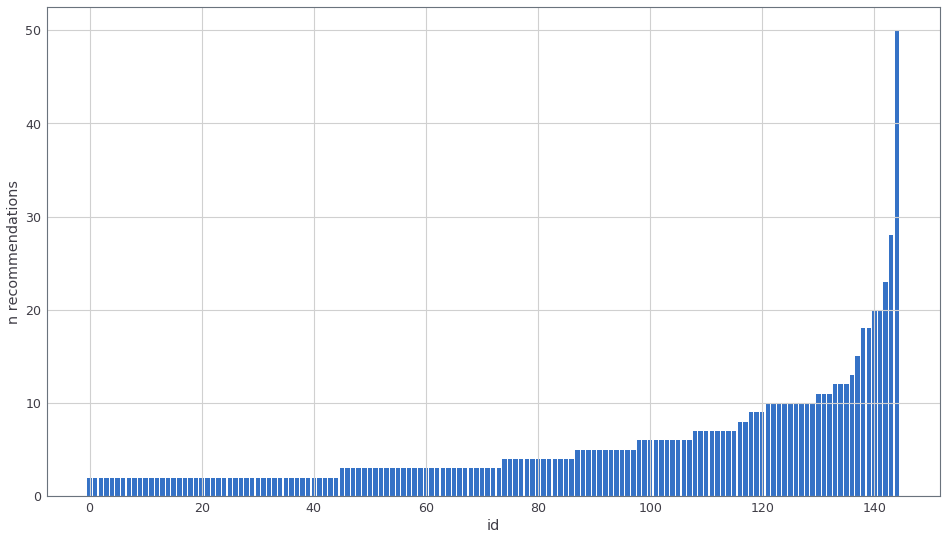

In [31]:
D, I = query(indexL2, bcq_action)
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts[counts>1])), sorted(counts[counts>1]))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")
l2_bcq = counts

Text(0, 0.5, 'n counts')

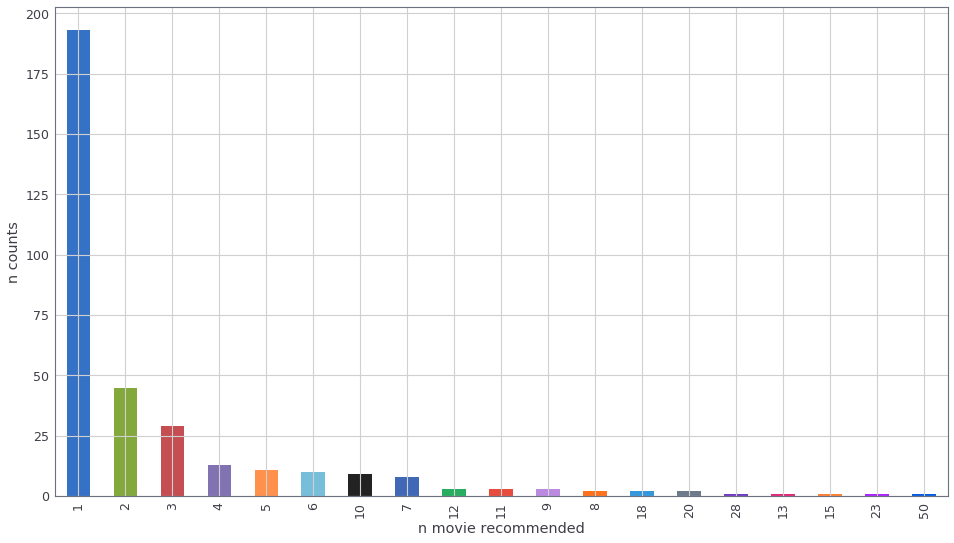

In [32]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

## InnerProduct

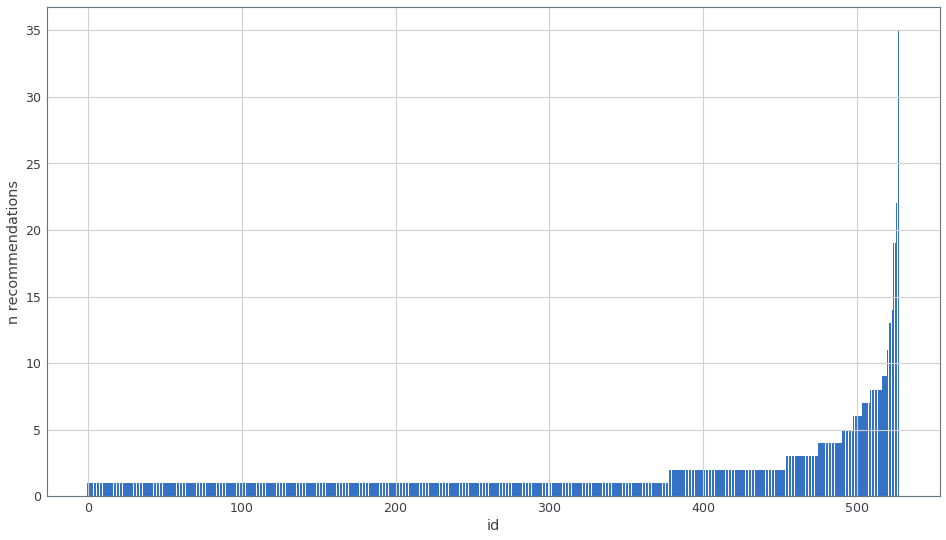

In [33]:
D, I = query(indexIP, bcq_action)
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts)), sorted(counts))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")
ip_bcq = counts

Text(0, 0.5, 'n counts')

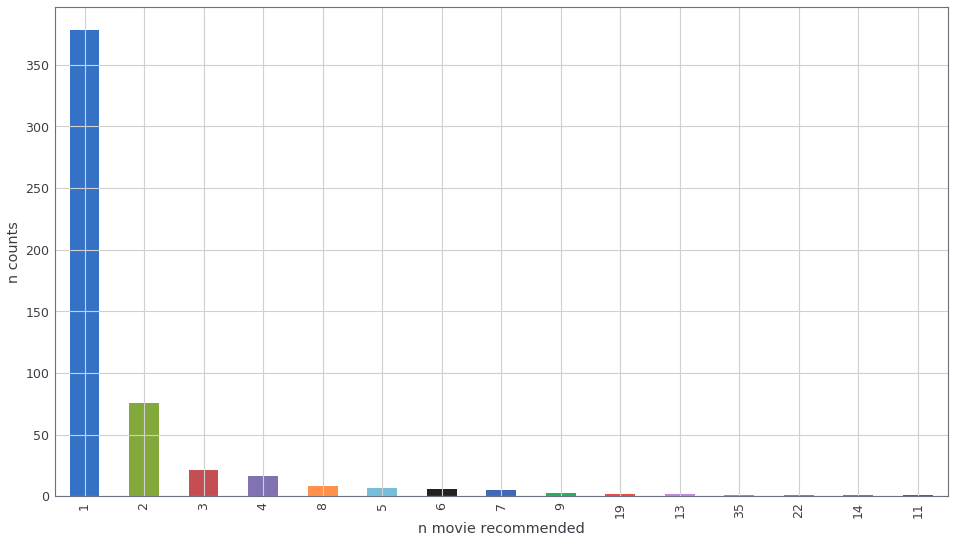

In [34]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

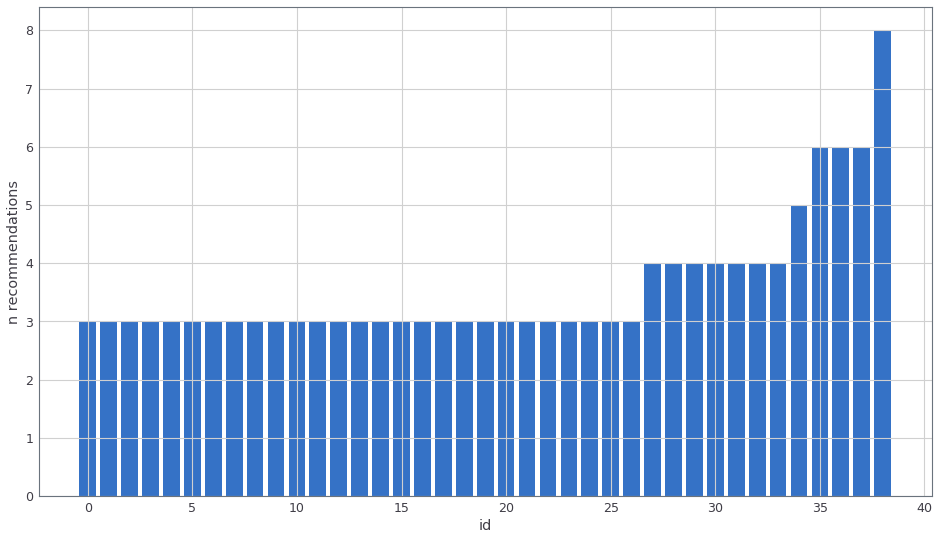

In [35]:
%matplotlib inline

D, I = query(indexCOS, normalize(bcq_action, axis=1, norm='l2'))
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts[counts>2])), sorted(counts[counts>2]))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")

cos_bcq = counts

# Grouped comparison

## L2 top 30

In [36]:
def plot_comp(ddpg, td3, bcq):
    barWidth = 0.25
    r1 = np.arange(len(ddpg))[:30]
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    plt.figure(figsize=(16, 9))

    plt.bar(r1, ddpg, width=barWidth, edgecolor='white', label='ddpg')
    plt.bar(r2, td3, width=barWidth, edgecolor='white', label='td3')
    plt.bar(r3, bcq, width=barWidth, edgecolor='white', label='bcq')

    # Add xticks on the middle of the group bars
    plt.xlabel('id')
    plt.ylabel('n recommended')

    # Create legend & Show graphic
    plt.legend()
    plt.show()

In [37]:
def plot_counts(l2_ddpg, l2_td3, l2_bcq):
    l2_ddpg_counts, l2_td3_counts, l2_bcq_counts = [pd.Series(i).value_counts() for i in [l2_ddpg, l2_td3, l2_bcq]]
    l2_ddpg_counts, l2_td3_counts, l2_bcq_counts = [i[i > 1] for i in [l2_ddpg_counts, l2_td3_counts, l2_bcq_counts]]

    unique_idx = l2_ddpg_counts.index.unique()| l2_td3_counts.index.unique() | l2_bcq_counts.index.unique()

    for arr in [l2_ddpg_counts, l2_td3_counts, l2_bcq_counts]:
        for i in unique_idx:
            if i not in arr:
                arr[i] = 0

    barWidth = 0.25
    r1 = np.arange(len(l2_ddpg_counts))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    plt.figure(figsize=(16, 9))

    plt.bar(r1, l2_ddpg_counts, width=barWidth, edgecolor='white', label='ddpg')
    plt.bar(r2, l2_td3_counts, width=barWidth, edgecolor='white', label='td3')
    plt.bar(r3, l2_bcq_counts, width=barWidth, edgecolor='white', label='bcq')

    # Add xticks on the middle of the group bars
    plt.xlabel('n recommended')
    plt.ylabel('counts')

    # Create legend & Show graphic
    plt.legend()
    plt.show()

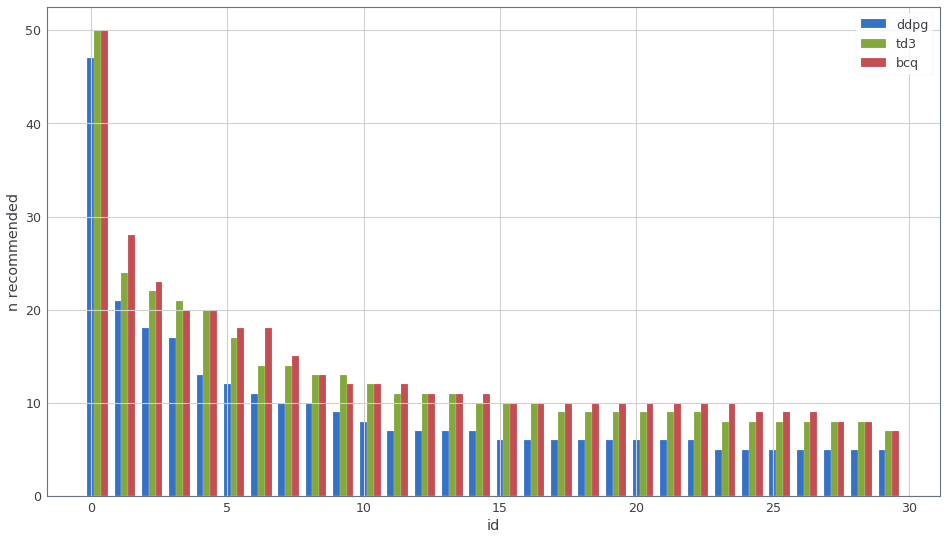

In [38]:
l2_ddpg_ = np.sort(l2_ddpg)[::-1][:30]
l2_td3_  = np.sort(l2_td3)[::-1][:30]
l2_bcq_  = np.sort(l2_bcq)[::-1][:30]

plot_comp(l2_ddpg_, l2_td3_, l2_bcq_)

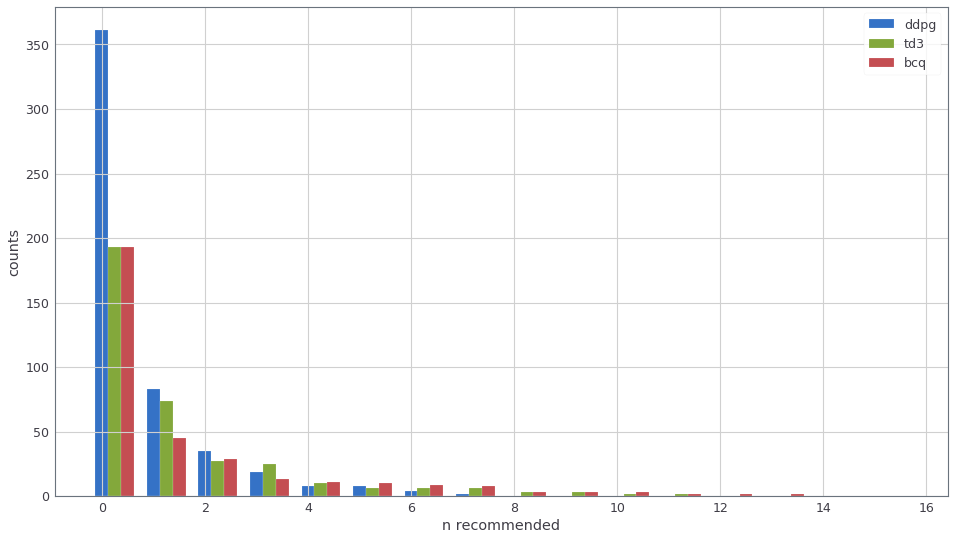

In [39]:
plot_counts(l2_ddpg, l2_td3, l2_bcq)

## InnerProduct top 30

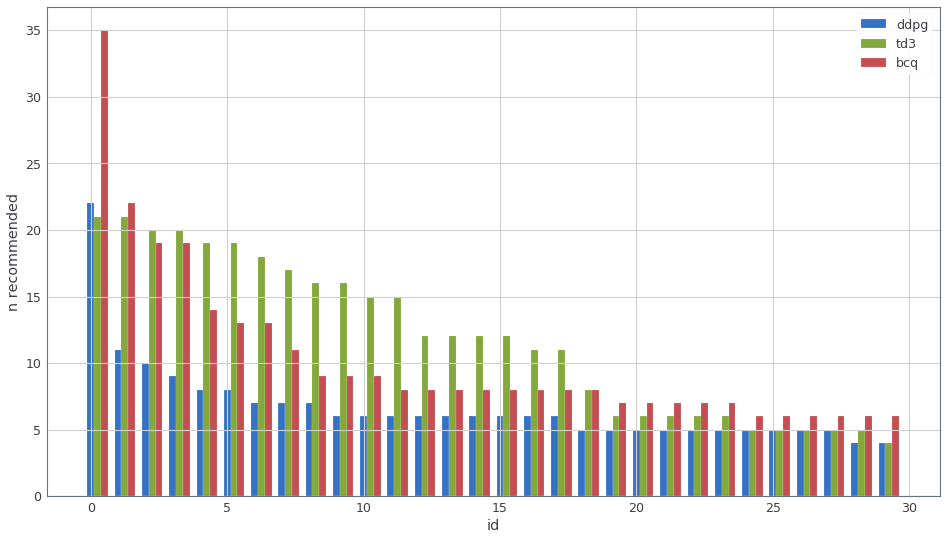

In [40]:
ip_ddpg_ = np.sort(ip_ddpg)[::-1][:30]
ip_td3_  = np.sort(ip_td3)[::-1][:30]
ip_bcq_  = np.sort(ip_bcq)[::-1][:30]

plot_comp(ip_ddpg_, ip_td3_, ip_bcq_)

## InnerProduct top 30-50

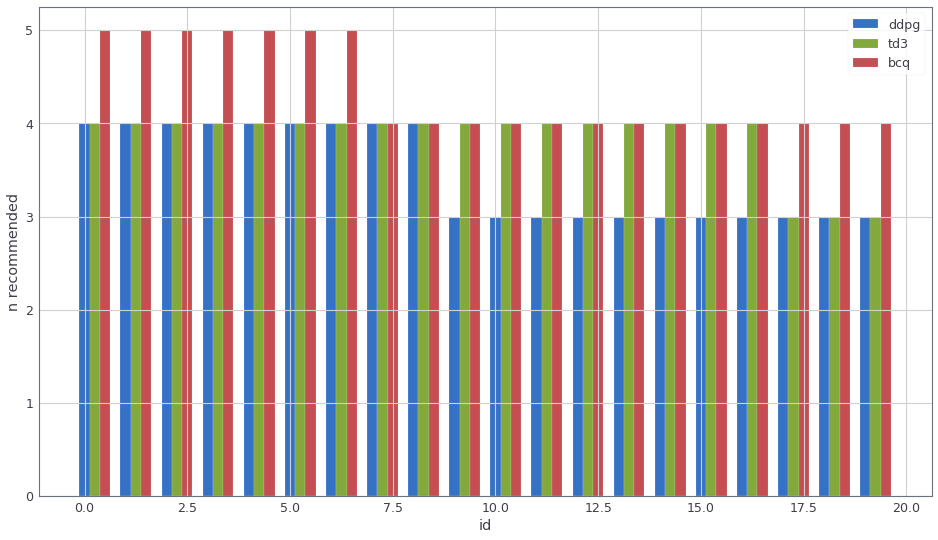

In [41]:
ip_ddpg_ = np.sort(ip_ddpg)[::-1][30:50]
ip_td3_  = np.sort(ip_td3)[::-1][30:50]
ip_bcq_  = np.sort(ip_bcq)[::-1][30:50]

plot_comp(ip_ddpg_, ip_td3_, ip_bcq_)

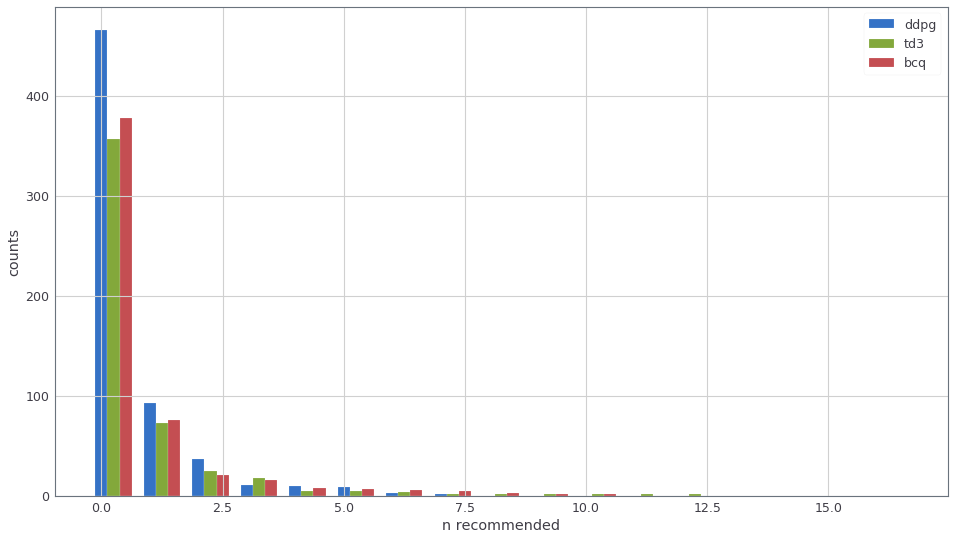

In [42]:
plot_counts(ip_ddpg, ip_td3, ip_bcq)

## Cosine Distance

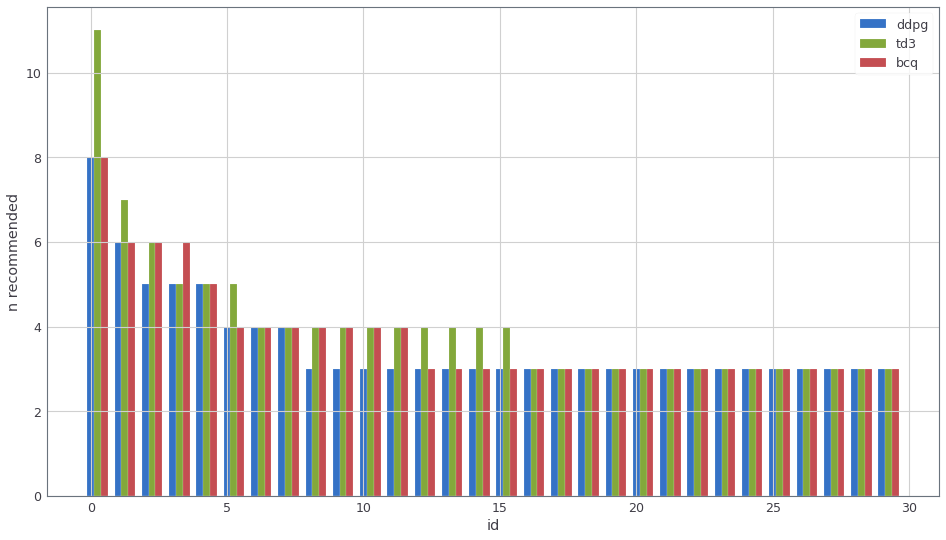

In [43]:
cos_ddpg_ = np.sort(cos_ddpg)[::-1][:30]
cos_td3_  = np.sort(cos_td3)[::-1][:30]
cos_bcq_  = np.sort(cos_bcq)[::-1][:30]
plot_comp(cos_ddpg_, cos_td3_, cos_bcq_)

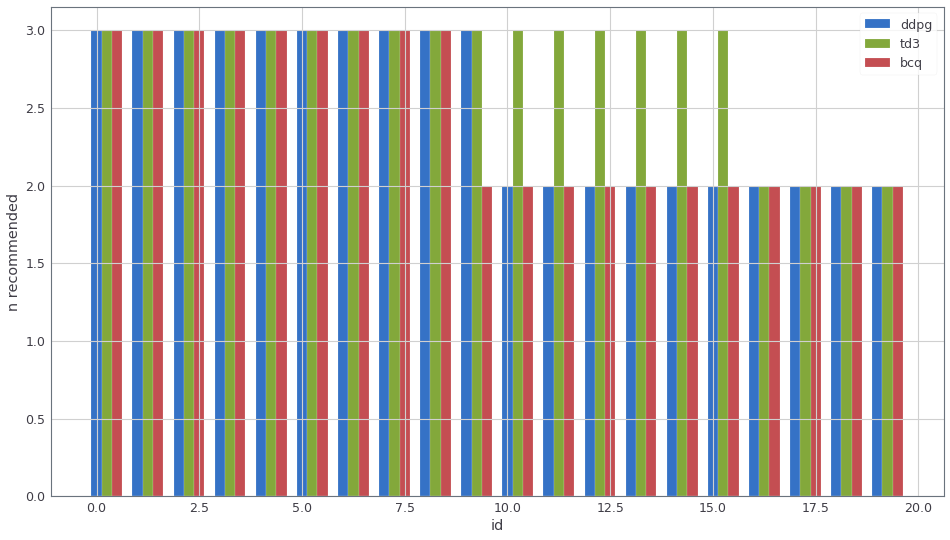

In [44]:
cos_ddpg_ = np.sort(cos_ddpg)[::-1][30:50]
cos_td3_  = np.sort(cos_td3)[::-1][30:50]
cos_bcq_  = np.sort(cos_bcq)[::-1][30:50]
plot_comp(cos_ddpg_, cos_td3_, cos_bcq_)

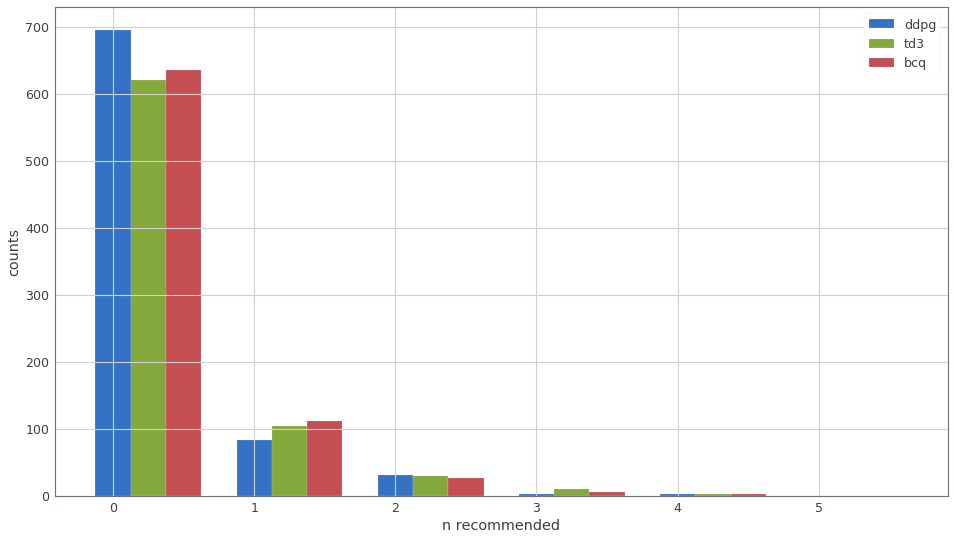

In [45]:
plot_counts(cos_ddpg, cos_td3, cos_bcq)